# Cuaderno de entrenamiento de modelos clásicos

En este cuaderno se realizarán los entrenamientos de los siguientes modelos clásicos de Machine Learning para el Trabajo de Fin de Grado:
- Naive Bayes
- Decision Trees

Autor: David Revillas
Mail: drevillas002@ikasle.ehu.eus
Fecha: 25-02-2020

# Instalación de módulos
Con la siguiente instrucción se instalan las librerías necesarias para ejecutar los scripts presentes en este Trabajo.

In [1]:
!pip install --upgrade numpy matplotlib scikit-learn "pandas>=1.0.1" tpot graphviz xgboost

Requirement already up-to-date: numpy in /home/david/Git/Football-api/venv/lib/python3.7/site-packages (1.18.2)
Requirement already up-to-date: matplotlib in /home/david/Git/Football-api/venv/lib/python3.7/site-packages (3.2.1)
  Using cached scikit_learn-0.22.2.post1-cp37-cp37m-manylinux1_x86_64.whl (7.1 MB)
Requirement already up-to-date: pandas>=1.0.1 in /home/david/Git/Football-api/venv/lib/python3.7/site-packages (1.0.3)
Requirement already up-to-date: tpot in /home/david/Git/Football-api/venv/lib/python3.7/site-packages (0.11.1)
Requirement already up-to-date: graphviz in /home/david/Git/Football-api/venv/lib/python3.7/site-packages (0.13.2)
Requirement already up-to-date: xgboost in /home/david/Git/Football-api/venv/lib/python3.7/site-packages (1.0.2)
ERROR: footballapi 0.9.4 has requirement ruia==0.6.4, but you'll have ruia 0.6.5 which is incompatible.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:

# Importación de módulos

In [2]:
import configparser
import os

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

# Save models
from joblib import dump

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
%matplotlib inline

# Configuración

Definimos la ruta al archivo de configuración y lo cargamos

In [3]:
config = configparser.ConfigParser(interpolation=configparser.BasicInterpolation())
path = '../'
config.read(os.path.join(path, 'data', 'settings.cfg'))

['../data/settings.cfg']

## Definir algunas constantes
### Clases
- 2: Corresponde a dos clases, `0` para indicar que el ganador es el local y `1` para indicar lo contrario.
- 3: Corresponde a tres clases, `0` para indicar que el ganador es el local, `1` para indicar empate y `2` 
para indicar ganador visitante.

In [4]:
num_clases = 3

### Columnas del DataFrame
Definir el nombre de las columnas

In [5]:
columnas = ["P", "L_O", "L_T", "L_MO", "L_POT", "L_ME", "L_DE", "L_P", "V_O", "V_T", "V_MO", "V_POT", "V_ME", "V_DE", "V_P", "R"]

### Equipos a analizar

- `all`: Todos los equipos de la base de datos.
- `id`: id concreto del equuipo a analizar. Por ejemplo, `92` corresponde a la Real Sociedad.

In [6]:
fd_id_equipo = 'all'
# fd_id_equipo = '92'

# Carga de datos
Cargar los datos de los partidos referentes a las temporadas 2017-2018, 2018-2019 y 2019-2020 desde los archivos `.csv`
generados previamente.

In [7]:
files = [config['PATHS']['csv_file'].format(temporada=i, fd_id_equipo=fd_id_equipo, 
                                            num_res=num_clases) for i in ["17-18", "18-19", "19-20"]]

# Concatenar varios csv en un mismo dataframe
# https://stackoverflow.com/a/21232849
tmp = []
for t, f in enumerate(files, start=1):
    print(f"\r[*] Cargando temporada: {t}/{len(files)}", end="")
    df = pd.read_csv(f, index_col='P', header=0, names=columnas, dtype=np.float64)
    tmp.append(df)   

df = pd.concat(tmp, axis=0, ignore_index=True, names=columnas)
df.R.astype(np.int8)
print(f"\r[+] Temporadas cargadas", end="")

[+] Temporadas cargadas

In [8]:
df

L_O     L_T    L_MO   L_POT    L_ME   L_DE    L_P     V_O     V_T  \
0     1352.0  1722.0  1859.0  1822.0  2034.0  885.0  383.0  1515.0  1995.0   
1     1409.0  1842.0  1917.0  1795.0  2038.0  959.0  382.0  1451.0  1897.0   
2     1427.0  1936.0  2006.0  1824.0  2143.0  951.0  350.0  1476.0  1804.0   
3     1378.0  1813.0  1941.0  1899.0  2163.0  921.0  358.0  1584.0  2095.0   
4     1448.0  1919.0  1940.0  1918.0  2184.0  956.0  391.0  1339.0  1717.0   
...      ...     ...     ...     ...     ...    ...    ...     ...     ...   
2921  1307.0  1675.0  1835.0  1761.0  1915.0  822.0  377.0  1168.0  1671.0   
2922  1295.0  1715.0  1838.0  1831.0  1919.0  829.0  359.0  1232.0  1651.0   
2923  1283.0  1562.0  1830.0  1703.0  1800.0  789.0  360.0  1238.0  1607.0   
2924  1244.0  1615.0  1794.0  1749.0  1926.0  828.0  340.0  1220.0  1529.0   
2925  1206.0  1615.0  1826.0  1735.0  1853.0  792.0  321.0  1417.0  1797.0   

        V_MO   V_POT    V_ME    V_DE    V_P    R  
0     1987.0  1878.0  2219.0   989.0  422.0  1.0  
1     1761.0  1691.0  2099.0   930.0  407.0  2.0  
2     1890.0  1848.0  2082.0   942.0  378.0  1.0  
3     2034.0  1999.0  2326.0  1030.0  406.0  2.0  
4     1923.0  1801.0  2038.0   867.0  365.0  1.0  
...      ...     ...     ...     ...    ...  ...  
2921  1889.0  1778.0  1903.0   803.0  353.0  0.0  
2922  1844.0  1637.0  1921.0   838.0  329.0  0.0  
2923  1832.0  1675.0  1815.0   786.0  346.0  0.0  
2924  1802.0  1677.0  1772.0   814.0  351.0  2.0  
2925  1854.0  1799.0  2051.0   839.0  373.0  1.0  

[2926 rows x 15 columns]

## Estadística descriptiva

In [9]:
df.describe()

L_O          L_T         L_MO        L_POT         L_ME  \
count  2926.000000  2926.000000  2926.000000  2926.000000  2926.000000   
mean   1358.406015  1767.695147  1885.872864  1805.306562  2020.700273   
std      98.718319   126.035138    90.239527    87.322939   136.035905   
min    1120.000000  1447.000000  1601.000000  1545.000000  1659.000000   
25%    1283.000000  1675.000000  1824.000000  1744.000000  1923.000000   
50%    1357.000000  1759.000000  1881.000000  1803.000000  2018.000000   
75%    1429.000000  1851.000000  1939.000000  1860.000000  2121.000000   
max    1635.000000  2141.000000  2212.000000  2074.000000  2362.000000   

              L_DE          L_P          V_O          V_T         V_MO  \
count  2926.000000  2926.000000  2926.000000  2926.000000  2926.000000   
mean    885.873889   366.716336  1355.328776  1764.458305  1882.852700   
std      62.295761    47.897970    98.737843   126.266602    91.032402   
min     742.000000    46.000000  1109.000000  1447.000000  1601.000000   
25%     838.000000   351.000000  1277.000000  1673.000000  1819.000000   
50%     888.000000   371.000000  1354.500000  1757.000000  1878.000000   
75%     930.000000   393.000000  1425.000000  1846.000000  1936.000000   
max    1050.000000   444.000000  1646.000000  2119.000000  2183.000000   

             V_POT         V_ME         V_DE          V_P            R  
count  2926.000000  2926.000000  2926.000000  2926.000000  2926.000000  
mean   1803.699248  2018.759057   886.095352   365.606630     0.846206  
std      87.116830   135.070159    62.203351    51.435663     0.845863  
min    1503.000000  1659.000000   742.000000    46.000000     0.000000  
25%    1742.000000  1922.000000   838.000000   350.000000     0.000000  
50%    1802.000000  2018.000000   889.000000   371.000000     1.000000  
75%    1859.000000  2118.750000   930.000000   393.000000     2.000000  
max    2077.000000  2383.000000  1048.000000   444.000000     2.000000

### Comprobar si esta balanceada

In [10]:
df['R'].value_counts()

0.0    1306
2.0     856
1.0     764
Name: R, dtype: int64

# Preprocesamiento
Comenzar separando las variables predictoras y la clase en conjuntos de entrenamiento y test.

In [11]:
X = df.loc[:, columnas[1:-1]].values
y = df[columnas[-1]].values.astype(int).ravel()

# Random state
rs = 51
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rs)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (2633, 14)
Test shape: (293, 14)


## TPOT

TPOT es una herramienta orientada al Machine Learning que optimiza el flujo de trabajo con programación genética. De esta manera se puede establecer *pipeline* "óptimo" que devuelva buenos resultados

In [12]:
# tpot = TPOTClassifier(generations=50, population_size=50, verbosity=2, n_jobs=-1, cv=10, 
#                       scoring='accuracy', 
#                       early_stop=10,
#                      )
# tpot.fit(X_train, y_train)
# print(tpot.score(X_test, y_test))
# tpot.export(f'tpot_{fd_id_equipo}_{num_clases}.py') 

## Estandarización
***Feature scaling through standardization (or Z-score normalization) can be an important preprocessing step for many 
machine learning algorithms. Standardization involves rescaling the features such that they have the properties of a 
standard normal distribution with a mean of zero and a standard deviation of one.*** [Importance of Feature Scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py)

In [13]:
# scaler = preprocessing.MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# print(X)

## Visualización del problema
### Reducción de la dimensionalidad
Mediante el [análisis de las componentes principales](https://es.wikipedia.org/wiki/An%C3%A1lisis_de_componentes_principales) 
se pueden reducir las dimensiones para poder visualizarlas en un gráfico. Puesto que esta reducción hace que se pierda 
información, hay que considerar utilizarla si no se alcanza una varianza arbitaria del 85%, por ejemplo.

Sum: 0.8287758374397945


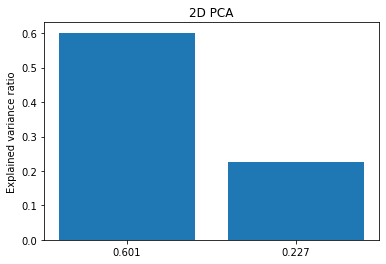

In [14]:
pca = PCA(2)
X_pca = pca.fit_transform(X)

n_componentes = [0, 1]
variance = pca.explained_variance_ratio_

plt.bar(n_componentes, variance, align='center')
plt.xticks(n_componentes, [round(i, 3) for i in variance])
plt.ylabel('Explained variance ratio')
plt.title('{0}D PCA'.format(len(n_componentes)))

print("Sum: {0}".format(sum(variance)))


### Representación en el plano
Una vez preprocesados los datos, se dibujan en el plano para comprobar si existe algún patrón que haga distinguir los 
casos. Hay que recordar que si se ha aplicado el PCA, se habrá perdido información.

Text(0, 0.5, 'Second Principal Component')

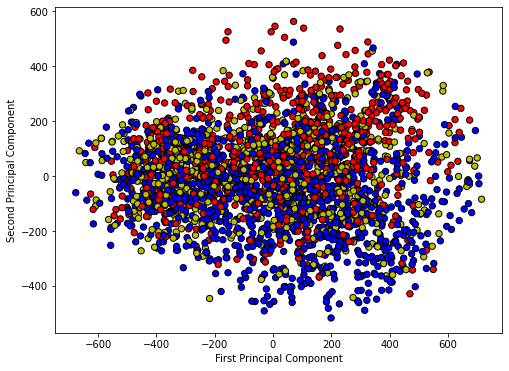

In [15]:
plt.figure(figsize=(8, 6))

# Color
col = []
for i in y:
    if i == 0:
        col.append('b')
    elif i == 1:
        col.append('y')
    elif i == 2:
        col.append('r')

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=col, edgecolors=(0, 0, 0), s=40)    
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

# Clasificadores
Crear instancias de los modelo de clasificación y entrenarlos con el conjunto de datos.



## Pipeline TPOT obtenido

In [16]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import RobustScaler
from tpot.builtins import ZeroCount

tpot_data = df.copy()
features = tpot_data.drop('R', axis=1)
training_features, testing_features, training_target, testing_target = \
    train_test_split(features, tpot_data['R'], random_state=rs, test_size=0.1)

if num_clases == 2:
    # Average CV score on the training set was: 0.6448233825791658
    exported_pipeline = make_pipeline(
        MinMaxScaler(),
        Normalizer(norm="max"),
        StackingEstimator(estimator=DecisionTreeClassifier(criterion="entropy", max_depth=4, min_samples_leaf=4, min_samples_split=6)),
        ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.35000000000000003, min_samples_leaf=18, min_samples_split=4, n_estimators=100)
    )
elif num_clases == 3:
    # Average CV score on the training set was: 0.563358302122347
    exported_pipeline = make_pipeline(
        RobustScaler(),
        RobustScaler(),
        ZeroCount(),
        ZeroCount(),
        ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.35000000000000003, min_samples_leaf=7, min_samples_split=3, n_estimators=100)
    )

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

#### Guardar el modelo aprendido

In [17]:
dump(exported_pipeline, os.path.join(config['PATHS']['prod'], f'tpot_{fd_id_equipo}_{num_clases}.joblib'))

['/home/david/Git/Football-api/prod/tpot_all_3.joblib']

## XGBoost

In [18]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

#### Guardar el modelo aprendido

In [19]:
dump(xgb, os.path.join(config['PATHS']['prod'], f'xgb_{fd_id_equipo}_{num_clases}.joblib'))

['/home/david/Git/Football-api/prod/xgb_all_3.joblib']

## Linear SVM

In [20]:
svm = LinearSVC(max_iter=1000, tol=1e-5)
svm.fit(X_train, y_train)

NameError: name 'LinearSVC' is not defined

#### Guardar el modelo aprendido

In [ ]:
dump(svm, os.path.join(config['PATHS']['prod'], f'svm_{fd_id_equipo}_{num_clases}.joblib'))


## Random Forest

In [ ]:
rfc = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
rfc.fit(X_train, y_train)

#### Guardar el modelo aprendido

In [ ]:
dump(rfc, os.path.join(config['PATHS']['prod'], f'rfc_{fd_id_equipo}_{num_clases}.joblib'))

## Ada Boost

In [ ]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)

#### Guardar el modelo aprendido

In [ ]:
dump(abc, os.path.join(config['PATHS']['prod'], f'abc_{fd_id_equipo}_{num_clases}.joblib'))

## [*Decision Trees*](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
Es un método fácil en el que el modelo trata de predecir la clase de una instancia utilizando reglas de aprendidas mediante la inferencia de los datos de entrenamiento.

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=5)
tree.fit(X_train, y_train)

#### Guardar el modelo aprendido

In [ ]:
dump(tree, os.path.join(config['PATHS']['prod'], f'tree_{fd_id_equipo}_{num_clases}.joblib'))

## [*Naïve Bayes*](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

In [ ]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)

#### Guardar el modelo aprendido

In [ ]:
dump(bayes, os.path.join(config['PATHS']['prod'], f'bayes_{fd_id_equipo}_{num_clases}.joblib'))

# Evaluación

## *Cross-Validation*

Se puede realizar una [Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) que separe los 
datos en `n` subconjutos, de manera que se entrenen `n` veces los modelos, entrenando con `n-1` subconjuntos distintos 
en cada iteración y probarlo con el conjunto restante

Se pueden utilizar los métodos ya implementados de *scikit-learn*:
1. [*cross validate*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html): Returns an array of scores of the estimator for each run of the cross validation. A dict of arrays containing the score/time arrays for each scorer is returned.
2. [*cross-val-score*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html): Returns an array of scores of the estimator for each run of the cross validation. Devuelve la **exactitud** de la clasificación por cada iteración.
3. [*cross_val_predict*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html): Generate cross-validated estimates for each input data point. It is **not appropriate** to pass these predictions into an evaluation metric. Use *cross_validate* to measure generalization error.

En caso de que el conjunto de datos sea pequeño, se puede realizar una validación cruzada con tantas iteraciones como 
casos haya, técnica conocida como *Leave One Out*. Para ello, se puede pasar como parámetro `cv` el número de iteraciones 
o el iterador `LeaveOneOut()`.


### Modelo TPOT

In [ ]:
cv_tpot = cross_val_score(exported_pipeline, X_train, y_train, cv=10)
print("Train accuracy: %0.2f (+/- %0.2f)" % (cv_tpot.mean(), cv_tpot.std() * 2))

cm_tpot = confusion_matrix(testing_target, results)
print(classification_report(testing_target, results))
sn.heatmap(cm_tpot, annot=True, fmt='g', cmap=plt.cm.Blues)

### Modelo XGBoost

In [ ]:
cv_xgb = cross_val_score(xgb, X_train, y_train, cv=10)
print("Train accuracy: %0.2f (+/- %0.2f)" % (cv_xgb.mean(), cv_xgb.std() * 2))

y_pred = xgb.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
sn.heatmap(cm_xgb, annot=True, fmt='g', cmap=plt.cm.Blues)

### Modelo Linear SVM

In [ ]:
cv_svm = cross_val_score(svm, X_train, y_train, cv=10)
print("Train accuracy: %0.2f (+/- %0.2f)" % (cv_svm.mean(), cv_svm.std() * 2))

y_pred = svm.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
sn.heatmap(cm_svm, annot=True, fmt='g', cmap=plt.cm.Blues)

### Modelo Ada Boost

In [ ]:
cv_abc = cross_val_score(abc, X_train, y_train, cv=10)
print("Train accuracy: %0.2f (+/- %0.2f)" % (cv_abc.mean(), cv_abc.std() * 2))

y_pred = abc.predict(X_test)
cv_abc = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
sn.heatmap(cv_abc, annot=True, fmt='g', cmap=plt.cm.Blues)

In [ ]:
classification_report(y_test, y_pred)

### Modelo Random Forest

In [ ]:
cv_rfc = cross_val_score(rfc, X_train, y_train, cv=10)
print("Train accuracy: %0.2f (+/- %0.2f)" % (cv_rfc.mean(), cv_rfc.std() * 2))

y_pred = rfc.predict(X_test)
cv_rfc = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
sn.heatmap(cv_rfc, annot=True, fmt='g', cmap=plt.cm.Blues)

### Modelo Decision Tree

In [ ]:
cv_tree = cross_val_score(tree, X_train, y_train, cv=10)
print("Train accuracy: %0.2f (+/- %0.2f)" % (cv_tree.mean(), cv_tree.std() * 2))

y_pred = tree.predict(X_test)
cm_tree = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
sn.heatmap(cm_tree, annot=True, fmt='g', cmap=plt.cm.Blues)

# Entrenamos el árbol sólo para mostrarlo
dot_data = export_graphviz(tree, out_file=None, feature_names=columnas[1:-1]) 
graph = graphviz.Source(dot_data)
graph.render(f'dt_arch_{fd_id_equipo}_{num_clases}') 

### Modelo Naïve Bayes

In [ ]:
cv_nb = cross_val_score(bayes, X_train, y_train, cv=10)
print("Train accuracy: %0.2f (+/- %0.2f)" % (cv_nb.mean(), cv_nb.std() * 2))

y_pred = bayes.predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
sn.heatmap(cm_nb, annot=True, fmt='g', cmap=plt.cm.Blues)